This notebook is a follow up on the 2-3 dB variation I saw in the received levels from the speaker. I now suspect the culprit may actually be me. I may have altered the digital dial on the TotalMX that controls the output gain of the playback signal. 

### What was done
I played back the calibration signal repeatedly over the course of ~30 minutes and recorded sound using the GRAS 1/4" microphone. 

The mic was facing the speaker, and it was placed in the small hole in the 'wall'. 

In [1]:
import glob
import os
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import scipy.signal as signal 
import soundfile as sf

In [2]:
print(f'Notebook initiated {dt.datetime.now()}')

Notebook initiated 2021-04-21 18:48:37.885026


In [3]:
%matplotlib notebook

In [4]:
fs = 192000
b,a = signal.butter(2,5000/fs*0.5,'high')
highpass = lambda X: signal.filtfilt(b,a,X)
dB = lambda X : 20*np.log10(abs(X))
dbrms = lambda X: dB(np.sqrt(np.mean(X**2.0)))

In [5]:
wavfiles = glob.glob('2021-04-21/*.wav')
wavfiles

['2021-04-21\\2021-04-21gras_gaindB_46_azimuth_angle_0_2021-04-21_17-59-02.wav',
 '2021-04-21\\gras_gaindB_46_azimuth_angle_0_2021-04-21_17-31-38.wav',
 '2021-04-21\\gras_gaindB_46_azimuth_angle_0_2021-04-21_17-32-02.wav',
 '2021-04-21\\gras_gaindB_46_azimuth_angle_0_2021-04-21_17-32-24.wav',
 '2021-04-21\\gras_gaindB_46_azimuth_angle_0_2021-04-21_17-32-47.wav',
 '2021-04-21\\gras_gaindB_46_azimuth_angle_0_2021-04-21_17-33-10.wav',
 '2021-04-21\\gras_gaindB_46_azimuth_angle_0_2021-04-21_17-33-33.wav',
 '2021-04-21\\gras_gaindB_46_azimuth_angle_0_2021-04-21_17-35-50.wav',
 '2021-04-21\\gras_gaindB_46_azimuth_angle_0_2021-04-21_18-01-53.wav',
 '2021-04-21\\gras_gaindB_46_azimuth_angle_0_2021-04-21_18-09-17.wav',
 '2021-04-21\\gras_gaindB_46_azimuth_angle_0_2021-04-21_18-11-03.wav',
 '2021-04-21\\gras_gaindB_46_azimuth_angle_0_2021-04-21_18-12-03.wav',
 '2021-04-21\\gras_gaindB_46_azimuth_angle_0_2021-04-21_18-13-31.wav',
 '2021-04-21\\gras_gaindB_46_azimuth_angle_0_2021-04-21_18-19-00.wa

In [6]:
durns = [sf.info(each).duration for each in wavfiles]
print(np.unique(durns))

[18.]


In [7]:
half_durn = 9 # secs
half_durnsamples = int(half_durn*fs)
sweeps_section = int(1.5*fs)
audio_hp = []
tones_dbrms = []
audio_dbrms1half = []
audio_dbrms2half = []
sweeps_dbrms = []
silence_dbrms = []
tones_dbrms = []
for each in wavfiles:
    audio,fs = sf.read(each)
    highpassed = highpass(audio)
    audio_hp.append(highpassed)
    tones_dbrms.append(dbrms(highpassed[int(1.5*fs):]))
    audio_dbrms1half.append(dbrms(highpassed[int(1.5*fs):half_durnsamples]))
    audio_dbrms2half.append(dbrms(highpassed[half_durnsamples:]))
    sweeps_dbrms.append(dbrms(highpassed[int(0.5*fs):sweeps_section]))
    silence_dbrms.append(dbrms(highpassed[:int(0.5*fs)]))

angles = [each.split('_')[5] for each in wavfiles]

In [8]:
rec_levels = pd.DataFrame(data={'filepaths':wavfiles, 'tones_level':tones_dbrms,
                                'first_half':audio_dbrms1half, 'second_half': audio_dbrms2half,
                                'sweeps_level': sweeps_dbrms})



def extract_md_hhmmss(fname):
    
    ymd, time_wav = fname.split('_')[-2:]
    md = ymd[5:]
    only_time = time_wav[:-4]
    return md + ',' + only_time
def extract_angle(fname):
    angle_value = fname.split('_')[5]
    return angle_value

rec_levels['filename'] = rec_levels['filepaths'].apply(lambda X: os.path.split(X)[-1])
rec_levels['rec_time'] = rec_levels['filename'].apply(extract_md_hhmmss)
rec_levels['angle'] = rec_levels['filename'].apply(extract_angle)
rec_levels = rec_levels.sort_values('rec_time')

<IPython.core.display.Javascript object>


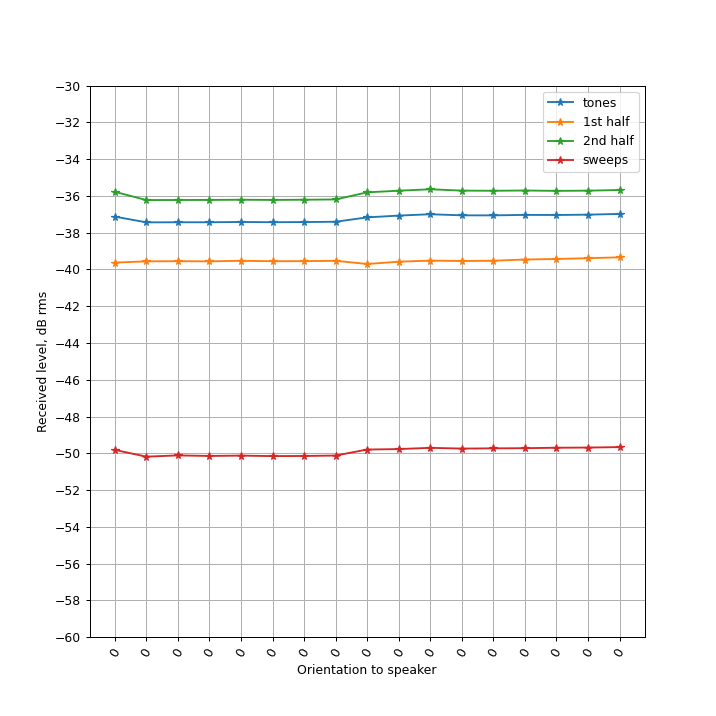

In [9]:
plt.figure(figsize=(8,8))
plt.plot(tones_dbrms,'-*',label='tones')
plt.plot(audio_dbrms1half,'-*',label='1st half')
plt.plot(audio_dbrms2half,'-*',label='2nd half')
plt.plot(sweeps_dbrms,'-*',label='sweeps')
plt.xticks(range(len(wavfiles)),angles,rotation=60);
plt.legend()
plt.ylim(-60,-30);plt.yticks(np.arange(-60,-28,2));plt.grid()
plt.ylabel('Received level, dB rms');plt.xlabel('Orientation to speaker')
plt.savefig('imgs/follow-up_2021-04-21.png')

<IPython.core.display.Javascript object>


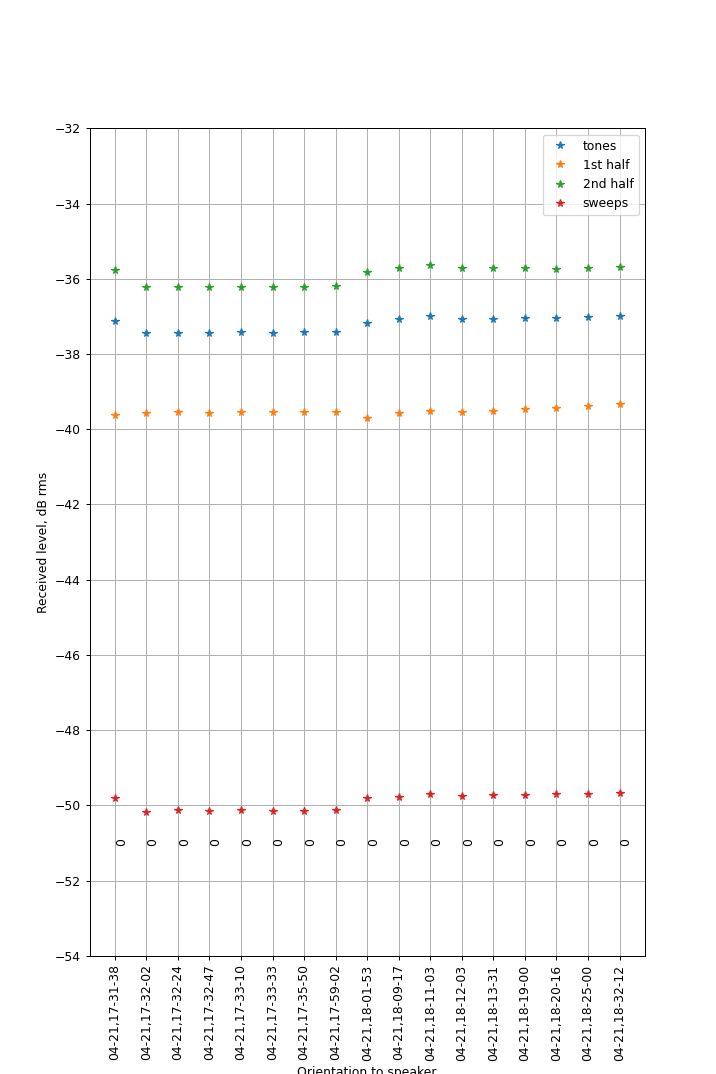

Text(0.5, 0, 'Orientation to speaker')

In [10]:
plt.figure(figsize=(8,12))
plt.plot(rec_levels['tones_level'],'*',label='tones')
plt.plot(rec_levels['first_half'],'*',label='1st half')
plt.plot(rec_levels['second_half'],'*',label='2nd half')
plt.plot(rec_levels['sweeps_level'],'*',label='sweeps')
for i,(theta, each) in enumerate(zip(rec_levels['angle'],rec_levels['sweeps_level'])):
    plt.text(i,np.round(each)-1, theta, rotation=90)

plt.xticks(range(len(wavfiles)),rec_levels['rec_time'],rotation=90,fontsize=10);
plt.legend()
plt.ylim(-54,-32);plt.yticks(np.arange(-54,-30,2));plt.grid()
plt.ylabel('Received level, dB rms');plt.xlabel('Orientation to speaker')

### Playback levels show extreme stability. 

There is a <1dB variation in playback level seen in my data. 

I didn't change anything apart from the microphone (switched from the SMP1 to GRAS 1/4"), and noticing the digital output gain which I'd moved to ```-8 UFL```, instead of the typical ```-6 UFL``` it displays on double clicking the slider. 

I strongly suspect the variation in playback level had more to do with my silliness than anything else. 

In [11]:
print(f'Notebook last run {dt.datetime.now()}')

Notebook last run 2021-04-21 18:48:41.757413
